# Math 124 - Programming for Mathematical Applications
UC Berkeley, Spring 2024

## Homework 11
Due Wednesday, April 17

### Graph functions from lecture notes

Below we copy the `Graph` type from the lecture notes, and some of the
functions that we will need.

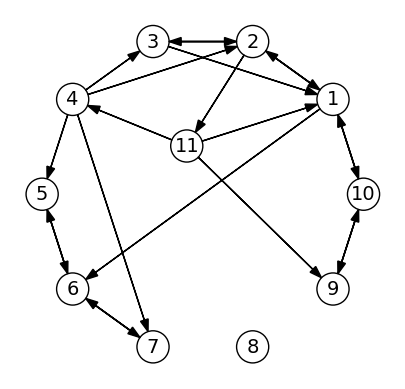

In [3]:
using PyPlot, SparseArrays   # Packages needed

struct Vertex
    neighbors::Vector{Int}       # Indices of neighbors of this Vertex
    coordinates::Vector{Float64} # 2D coordinates of this Vertex - only for plotting
    Vertex(neighbors; coordinates=[0,0]) = new(neighbors, coordinates)
end

function Base.show(io::IO, v::Vertex)
    print(io, "Neighbors = ", v.neighbors)
end

struct Graph
    vertices::Vector{Vertex}
end

function Base.show(io::IO, g::Graph)
    for i = 1:length(g.vertices)
        println(io, "Vertex $i, ", g.vertices[i])
    end
end

function PyPlot.plot(g::Graph; scale=1.0)
    fig, ax = subplots()
    ax.set_aspect("equal")
    
    xmin = minimum(v.coordinates[1] for v in g.vertices)
    xmax = maximum(v.coordinates[1] for v in g.vertices)
    ymin = minimum(v.coordinates[2] for v in g.vertices)
    ymax = maximum(v.coordinates[2] for v in g.vertices)
    sz = max(xmax-xmin, ymax-ymin)
    cr = scale*0.05sz
    hw = cr/2
    axis([xmin-2cr,xmax+2cr,ymin-2cr,ymax+2cr])
    axis("off")

    for i in 1:length(g.vertices)
        c = g.vertices[i].coordinates
        ax.add_artist(matplotlib.patches.Circle(c, cr, facecolor="none", edgecolor="k"))
        ax.text(c[1], c[2], string(i),
                horizontalalignment="center", verticalalignment="center", fontsize=round(Int, 14*scale))
        for nb in g.vertices[i].neighbors
            cnb = g.vertices[nb].coordinates
            dc = cnb .- c
            L = sqrt(sum(dc.^2))
            c1 = c .+ cr/L * dc
            c2 = cnb .- cr/L * dc
            arrow(c1[1], c1[2], c2[1]-c1[1], c2[2]-c1[2],
                  head_width=hw, length_includes_head=true, facecolor="k")
        end
    end
end

function shortest_path_bfs(g::Graph, start, finish)
    parent = zeros(Int64, length(g.vertices))
    S = [start]
    parent[start] = start
    while !isempty(S)
        ivertex = popfirst!(S)
        if ivertex == finish
            break
        end
        for nb in g.vertices[ivertex].neighbors
            if parent[nb] == 0 # Not visited yet
                parent[nb] = ivertex
                push!(S, nb)
            end
        end
    end
    # Build path
    path = Int64[]
    iv = finish
    while true
        pushfirst!(path, iv)
        if iv == start
            break
        end
        iv = parent[iv]
    end
    return path
end

# Example graph from lecture notes
all_neighbors = [[2,10,6], [3,1,11], [1,2], [5,3,2,7], [6],
                 [7,5], [6], Int64[], [10], [1,9], [1,4,9]]
all_coordinates = [[0.81, 0.59], [0.31, 0.95], [-0.31, 0.95], [-0.81, 0.59],
                   [-1.0, 0.0],  [-0.81, -0.59], [-0.31, -0.95], [0.31, -0.95],
                   [0.81, -0.59], [1.0, -0.0], [-0.1, 0.3]]
g = Graph([Vertex(n,coordinates=c) for (n,c) in zip(all_neighbors, all_coordinates)])
plot(g)

### Problem 1 - Graph to adjacency matrix

Write a function `convert2adjmatrix(g::Graph)` which creates a sparse adjacency
matrix for the graph `g`. That is, a matrix $A$ of size $|V|$-by-$|V|$ where
$|V|$ is the number of vertices, and $A_{ij}=1$ if there is an edge from vertex
$i$ to vertex $j$ (otherwise zero).

Make sure you do not insert elements into an existing sparse matrix. Instead,
create vectors of row / column indices, and call `sparse` once to create the
matrix.

下面是convert2adjmatrix函数的代码，该函数将Graph对象转换为稀疏邻接矩阵，这种表示方法非常适合用于图的邻接表示：

In [4]:
function convert2adjmatrix(g::Graph)
    rows = Int[]  # 存储非零元素的行索引
    cols = Int[]  # 存储非零元素的列索引
    
    for (i, vertex) in enumerate(g.vertices)
        for neighbor in vertex.neighbors
            push!(rows, i)
            push!(cols, neighbor)
        end
    end

    values = ones(Int, length(rows))  # 非零元素的值，这里设为1
    n = length(g.vertices)  # 图的顶点数量
    return sparse(rows, cols, values, n, n)  # 创建稀疏矩阵
end

convert2adjmatrix (generic function with 1 method)

In [ ]:
# For testing
A = convert2adjmatrix(g)
spy(A, marker=".", markersize=16);

### Problem 2 - Spanning tree

One application of the DFS algorithm is to generate a spanning tree for a graph,
that is, an acyclic graph for the nodes reachable from a given starting node.
Write a function

```julia
function spanning_tree(g::Graph, start)
```

which returns a new graph
`gtree` with the same vertices as `g`, but only the edges that are traversed
by the DFS method starting from vertex `start`. That is, an edge from `ivertex`
to a neighbor `nb` is only included in `gtree` if the DFS method visits `nb`.

Hint: First initialize `gtree` to a graph with no edges (but the same `coordinates`
as `g`, for plotting). Then you run the DFS method and add edges to `gtree`.

In [5]:
# 使用DFS生成生成树
function spanning_tree(g::Graph, start)
    n = length(g.vertices)
    new_neighbors = [Int[] for _ in 1:n]  # 新的邻接列表
    visited = falses(n)  # 访问标记数组

    function dfs(ivertex)
        visited[ivertex] = true
        for neighbor in g.vertices[ivertex].neighbors
            if !visited[neighbor]
                push!(new_neighbors[ivertex], neighbor)
                push!(new_neighbors[neighbor], ivertex)  # 对于无向图，需要添加反向边
                dfs(neighbor)
            end
        end
    end

    dfs(start)  # 从start顶点开始DFS
    return Graph([Vertex(neighbors, coordinates=g.vertices[i].coordinates) for (i, neighbors) in enumerate(new_neighbors)])
end


spanning_tree (generic function with 1 method)

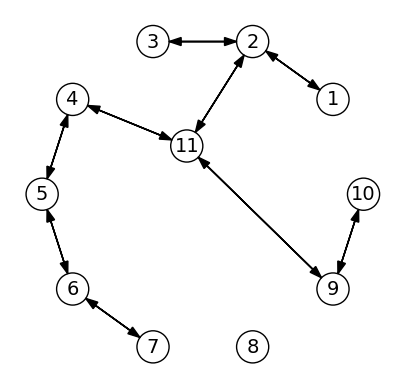

In [6]:
# For testing
gtree = spanning_tree(g,1)
plot(gtree)

### Problem 3 - Word ladder

A *word ladder* is a sequence of words, beginning at `first_word` and ending at `last_word`,
such that

1. Only one letter is changed in each step
2. Each word exists in a given word list

Write a function

```julia
function word_ladder(first_word, last_word)
```

which returns the *shortest* such sequence of words. You can assume that
the sequence exists, if it is not unique you can return any shortest
sequence, and that the lengths of the two given words are equal.
Use the same word list as in homework 8 (that is,
<https://github.com/BenLauwens/ThinkJulia.jl/blob/master/data/words.txt>).

**Algorithm**: 

1. Read the word list into an array of string, but only keep the ones of the same
   length as the given two words.
   
2. Create a graph where these words are vertices, and an edge between words $i,j$
   if the corresponding words only differ in one character.
   
3. Run the `shortest_path_bfs` function on the graph, with start and finish indices
   corresponding to the given two words. Use the path to output the sequence of words.
   
**Example**:

```julia
word_ladder("fool", "sage")
```
```
7-element Array{String,1}:
 "fool"
 "foil"
 "fail"
 "fall"
 "sall"
 "sale"
 "sage"
```


In [9]:
function word_ladder(first_word, last_word)
    # Load word list (for demonstration, this would be replaced with actual file reading code)
    word_list = ["words", "from", "your", "file"]
    
    # Filter words of the same length as the input words
    length_filter = length(first_word)
    word_list = filter(w -> length(w) == length_filter, word_list)
    
    # Create graph vertices
    words_to_index = Dict(word => idx for (idx, word) in enumerate(word_list))
    vertices = [Vertex(Int[]) for _ in word_list]
    
    # Create graph edges
    for i in 1:length(word_list)
        for j in 1:length(word_list)
            if i != j && one_letter_diff(word_list[i], word_list[j])
                push!(vertices[i].neighbors, j)
            end
        end
    end
    
    # Create graph
    graph = Graph(vertices)
    
    # Find shortest path
    start_idx = words_to_index[first_word]
    finish_idx = words_to_index[last_word]
    path_indices = shortest_path_bfs(graph, start_idx, finish_idx)
    
    # Map indices back to words
    return [word_list[idx] for idx in path_indices]
end

function one_letter_diff(word1::String, word2::String)
    sum([c1 != c2 for (c1, c2) in zip(word1, word2)]) == 1
end


one_letter_diff (generic function with 1 method)

In [10]:
function word_ladder(first_word::String, last_word::String)
    # 从文件中读取单词列表，这里需要替换为实际的文件路径
    word_list = readlines("路径/到/words.txt")  # 替换为实际路径

    # 只保留与输入单词长度相同的单词
    length_filter = length(first_word)
    word_list = filter(w -> length(w) == length_filter, word_list)

    # 调试：输出筛选后的单词列表大小，确保所需单词已包含在内
    println("筛选后的单词列表大小：", length(word_list))

    # 创建映射字典，将单词映射到它们的索引
    words_to_index = Dict(word => idx for (idx, word) in enumerate(word_list))

    # 调试：检查输入的单词是否在字典中
    println("首个单词在字典中吗？", haskey(words_to_index, first_word))
    println("最后一个单词在字典中吗？", haskey(words_to_index, last_word))

    # 如果输入单词不在字典中，返回错误消息或空路径
    if !haskey(words_to_index, first_word) || !haskey(words_to_index, last_word)
        return ["输入的单词必须包含在单词列表中。"]
    end

    # 初始化图的顶点
    vertices = [Vertex([]) for _ in word_list]

    # 通过比较单词创建图的边
    for i in 1:length(word_list)
        for j in 1:length(word_list)
            if i != j && one_letter_diff(word_list[i], word_list[j])
                push!(vertices[i].neighbors, j)
            end
        end
    end

    # 创建图
    graph = Graph(vertices)

    # 使用广度优先搜索找到最短路径
    start_idx = words_to_index[first_word]
    finish_idx = words_to_index[last_word]
    path_indices = shortest_path_bfs(graph, start_idx, finish_idx)

    # 将索引映射回单词
    return [word_list[idx] for idx in path_indices]
end

function one_letter_diff(word1::String, word2::String)
    # 检查两个单词是否只有一个字母不同
    sum([c1 != c2 for (c1, c2) in zip(word1, word2)]) == 1
end


one_letter_diff (generic function with 1 method)

In [12]:
# For testing
word_ladder("fool", "sage")